# **ICESat-2 ATL11 Rate of Height change over Time (dhdt)**

This Jupyter notebook will cover the calculation of
Ice Height Changes (dh) over Time (dt) using Linear Regression.
Focusing on the Antarctic continent, for the ICESat-2 time period.
To save on computational resources, we'll run through a few preprocessing steps:

1. Select essential points
  - Subset to geographic region of interest (optional)
  - Drop points without at least 2 valid heights across all ICESat-2 cycles
2. Calculate height range (h_range)
  - Done for points which are valid and in geographic region of interest
  - Uses the `deepicedrain.nanptp` function
3. Calculate rate of height change over time (dhdt)
  - Done for points with `h_range > 0.25 metres`
  - Uses the `deepicedrain.nan_linregress` function

Adapted from https://github.com/suzanne64/ATL11/blob/master/plotting_scripts/AA_dhdt_map.ipynb

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

import dask
import datashader
import deepicedrain
import holoviews as hv
import hvplot.pandas
import intake
import panel as pn
import pygmt
import scipy.stats

In [2]:
client = dask.distributed.Client(n_workers=72, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:41015 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 72 Cores: 72 Memory: 201.22 GB


# Select essential points

In [3]:
# Xarray open_dataset preprocessor to add fields based on input filename.
add_path_to_ds = lambda ds: ds.assign_coords(
    coords=intake.source.utils.reverse_format(
        format_string="ATL11.001z123/ATL11_{referencegroundtrack:04d}1x_{}_{}_{}.zarr",
        resolved_string=ds.encoding["source"],
    )
)

# Load ATL11 data from Zarr
ds: xr.Dataset = xr.open_mfdataset(
    paths="ATL11.001z123/ATL11_*_003_01.zarr",
    chunks={"cycle_number": 7},
    engine="zarr",
    combine="nested",
    concat_dim="ref_pt",
    parallel="True",
    preprocess=add_path_to_ds,
    backend_kwargs={"consolidated": True},
)

## Light pre-processing

- Reproject longitude/latitude to EPSG:3031 x/y
- Mask out low quality height data

In [4]:
# Calculate the EPSG:3031 x/y projection coordinates
ds["x"], ds["y"] = deepicedrain.lonlat_to_xy(
    longitude=ds.longitude, latitude=ds.latitude
)
# Set x, y, x_atc and y_atc as coords of the xarray.Dataset instead of lon/lat
ds: xr.Dataset = ds.set_coords(names=["x", "y", "x_atc", "y_atc"])
ds: xr.Dataset = ds.reset_coords(names=["longitude", "latitude"])

In [5]:
# Mask out low quality height data
ds["h_corr"]: xr.DataArray = ds.h_corr.where(cond=ds.fit_quality == 0)

## Trim out unnecessary values (optional)

There's ~220 million ATL11 points for the whole of Antarctica,
and not all of them will be needed depending on what you want to do.
To cut down on the number of data points the computer needs to work on,
we can:

- Subset to geographic region of interest
- Ensure there are at least 2 height values to calculate trend over time

In [6]:
# Dictionary of Antarctic bounding box locations with EPSG:3031 coordinates
regions: dict = {
    "kamb": deepicedrain.Region(
        name="Kamb Ice Stream",
        xmin=-411054.19240523444,
        xmax=-365489.6822096751,
        ymin=-739741.7702261859,
        ymax=-699564.516934089,
    ),
    "antarctica": deepicedrain.Region(
        "Antarctica", -2700000, 2800000, -2200000, 2300000
    ),
    "siple_coast": deepicedrain.Region(
        "Siple Coast", -1000000, 250000, -1000000, -100000
    ),
    "whillans_downstream": deepicedrain.Region(
        "Whillans Ice Stream (Downstream)", -400000, 0, -800000, -400000
    ),
    "whillans_upstream": deepicedrain.Region(
        "Whillans Ice Stream (Upstream)", -800000, -400000, -800000, -400000
    ),
}

In [7]:
# Subset dataset to geographic region of interest
placename: str = "antarctica"
region: deepicedrain.Region = regions[placename]
# ds = region.subset(ds=ds)

In [8]:
# We need at least 2 points to draw a trend line or compute differences
# So let's drop points with less than 2 valid values across all cycles
# Will take maybe 10-15 min to trim down ~220 million points to ~190 million
print(f"Originally {len(ds.ref_pt)} points")
# ds: xr.Dataset = ds.dropna(dim="ref_pt", thresh=2, subset=["h_corr"])
print(f"Trimmed to {len(ds.ref_pt)} points")

Originally 222790697 points
Trimmed to 222790697 points


### Optimize dataset for big calculations later

We'll rechunk the dataset to a reasonable chunk size,
and persist key dataset variables in memory so that the parallel
computations will be more efficient in later sections.

In [9]:
ds["h_corr"] = ds.h_corr.unify_chunks()

In [10]:
# Persist the height and time data in distributed memory
ds["h_corr"] = ds.h_corr.persist()
ds["delta_time"] = ds.delta_time.persist()

### Retrieve some basic information for plots later

Simply getting the number of cycles and date range
to put into our plots later on

In [11]:
# Get number of ICESat-2 cycles used
num_cycles: int = len(ds.cycle_number)

In [12]:
# Get first and last dates to put into our plots
min_date, max_date = ("2018-10-14", "2020-05-13")
if min_date is None:
    min_delta_time = np.nanmin(ds.delta_time.isel(cycle_number=0).data).compute()
    min_utc_time = deepicedrain.deltatime_to_utctime(min_delta_time)
    min_date: str = np.datetime_as_string(arr=min_utc_time, unit="D")
if max_date is None:
    max_delta_time = np.nanmax(ds.delta_time.isel(cycle_number=-1).data).compute()
    max_utc_time = deepicedrain.deltatime_to_utctime(max_delta_time)
    max_date: str = np.datetime_as_string(arr=max_utc_time, unit="D")
print(f"Handling {num_cycles} ICESat-2 cycles from {min_date} to {max_date}")

Handling 7 ICESat-2 cycles from 2018-10-14 to 2020-05-13


# Calculate height range (h_range)

A simple way of finding active subglacial lakes is to see where
there has been a noticeably rapid change in elevation over
a short period of time such as 2-5 metres a year (or ~4x91-day ICESat-2 cycles).
'Range of height' is quick way to do this,
basically just doing maximum height minus minimum height.

In [13]:
# Calculate height range across cycles, parallelized using dask
ds["h_range"]: xr.DataArray = xr.apply_ufunc(
    deepicedrain.nanptp,  # min point to max point (range) that handles NaN values
    ds.h_corr,
    input_core_dims=[["cycle_number"]],
    dask="allowed",
    output_dtypes=[ds.h_corr.dtype],
    kwargs={"axis": 1},
)

In [14]:
# %%time
# Compute height range. Also include all height and time info
ds_ht: xr.Dataset = ds[["h_range", "h_corr", "delta_time"]].compute()

CPU times: user 26min 6s, sys: 2min 21s, total: 28min 28s
Wall time: 27min 39s


In [15]:
# Non-parallelized
# h_range = deepicedrain.nanptp(a=ds.h_corr[0:1], axis=1)
# Ensure no height range values which are zero (usually due to only 1 data point)
# assert len(dask.array.argwhere(dsh.h_range <= 0.0).compute()) == 0

In [16]:
# Save or Load height range data
# ds_ht.to_zarr(store=f"ATLXI/ds_hrange_time_{placename}.zarr", mode="w", consolidated=True)
ds_ht: xr.Dataset = xr.open_dataset(
    filename_or_obj=f"ATLXI/ds_hrange_time_{placename}.zarr",
    chunks={"cycle_number": 7},
    engine="zarr",
    backend_kwargs={"consolidated": True},
)
# ds: xr.Dataset = ds_ht  # shortcut for dhdt calculation later

In [17]:
df_hr: pd.DataFrame = ds_ht.h_range.to_dataframe()

In [18]:
df_hr.describe()

,referencegroundtrack,x,x_atc,y,y_atc,h_range
count,2.227907e+08,2.227907e+08,2.227907e+08,2.227907e+08,2.227907e+08,2.185279e+08
mean,7.161673e+02,2.377766e+05,3.012191e+07,5.856300e+04,6.902618e+01,2.760067e-01
std,3.971910e+02,1.067813e+06,1.450394e+06,9.273166e+05,2.747885e+03,1.303986e+01
min,1.000000e+00,-4.371480e+06,2.563873e+07,-2.551004e+06,-4.352500e+03,0.000000e+00
25%,3.690000e+02,-4.513834e+05,2.887086e+07,-5.947182e+05,-3.351000e+03,4.614258e-02
50%,7.370000e+02,1.823700e+05,3.012053e+07,3.410330e+04,-1.500000e+00,8.886719e-02
75%,1.071000e+03,1.018170e+06,3.139198e+07,7.076581e+05,3.350500e+03,1.845703e-01
max,1.387000e+03,4.003066e+06,3.457507e+07,4.001236e+06,4.348500e+03,6.218927e+04


In [19]:
# Datashade our height values (vector points) onto a grid (raster image)
agg_grid: xr.DataArray = region.datashade(df=df_hr, z_dim="h_range")
print(agg_grid)

<xarray.DataArray (y: 1145, x: 1400)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 -2.698e+06 -2.694e+06 -2.69e+06 ... 2.794e+06 2.798e+06
  * y        (y) float64 -2.198e+06 -2.194e+06 -2.19e+06 ... 2.294e+06 2.298e+06


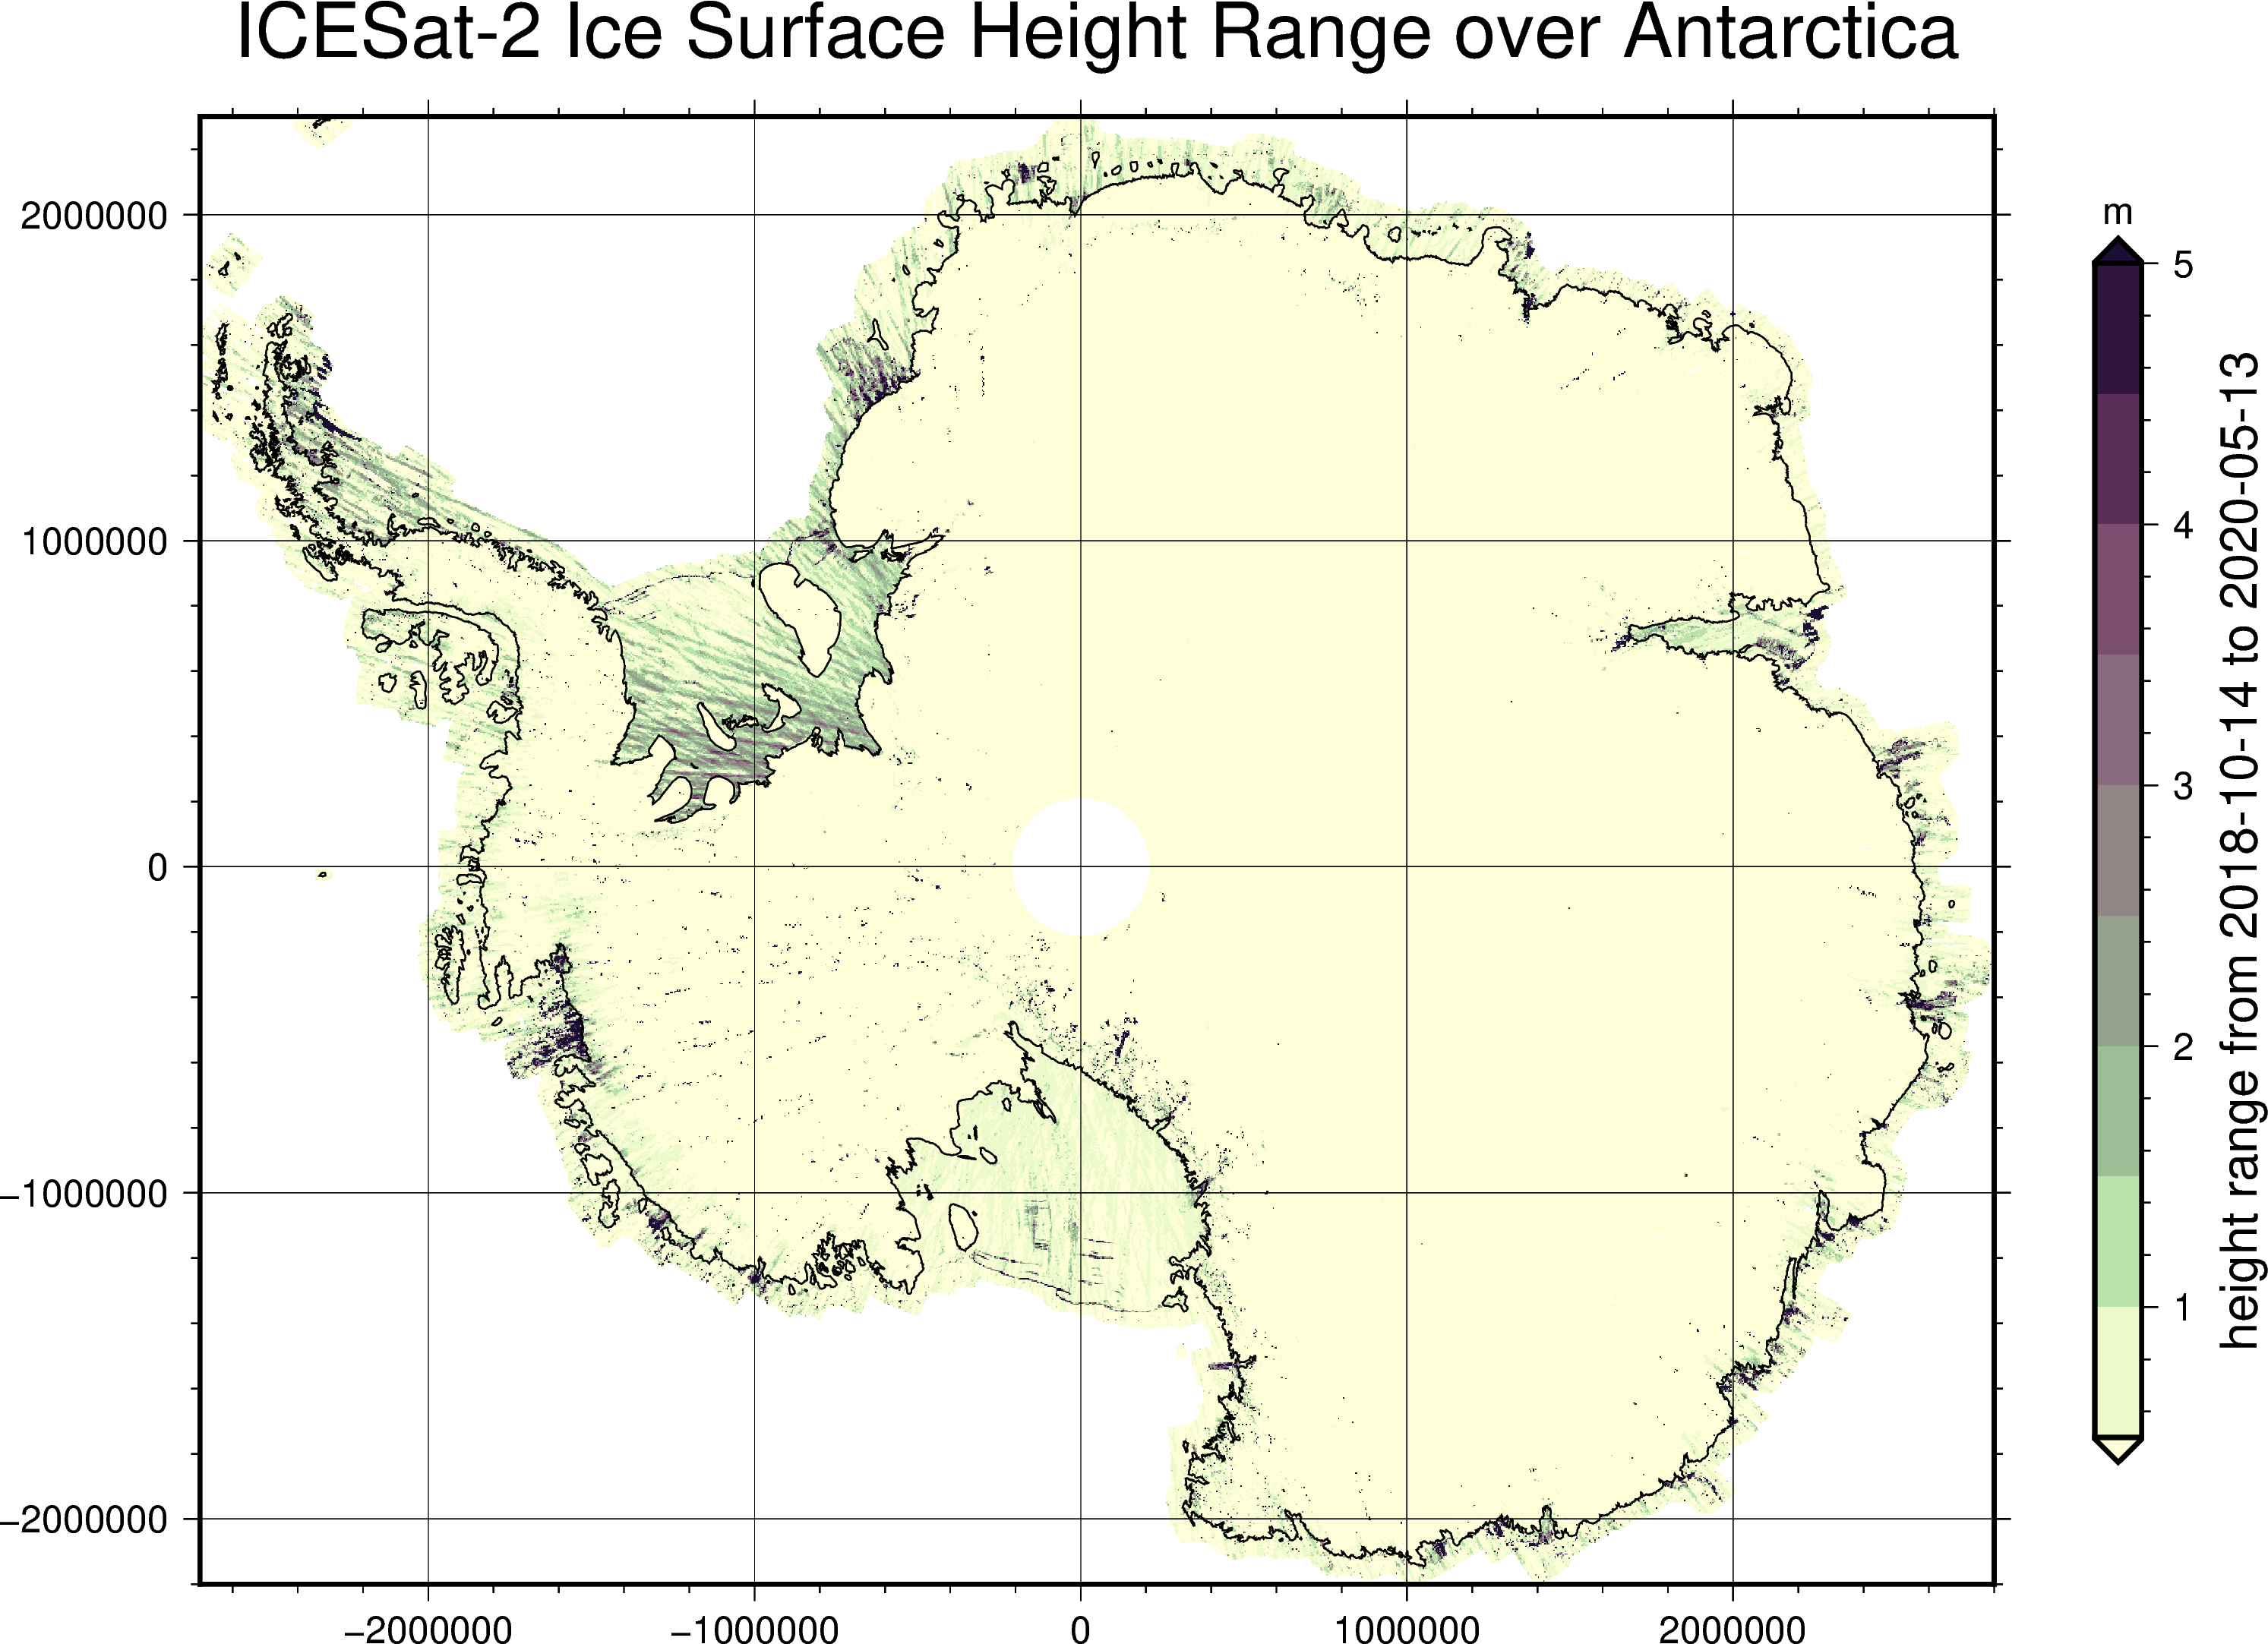

In [20]:
# Plot our map!
scale: int = region.scale
fig = pygmt.Figure()
pygmt.makecpt(cmap="tokyo", series=[0.5, 5, 0.5], reverse=True)
fig.grdimage(
    grid=agg_grid,
    region=region.bounds(),
    projection=f"x1:{scale}",
    frame=["afg", f'WSne+t"ICESat-2 Ice Surface Height Range over {region.name}"'],
    Q=True,
)
fig.colorbar(
    position="JCR+e",
    frame=["af", f'x+l"height range from {min_date} to {max_date}"', "y+lm"],
)
# for subglacial_lake in subglacial_lakes:
#     fig.plot(data=subglacial_lake, L=True, pen="thin")
fig.coast(
    region=region.bounds(),
    projection=f"s0/-90/-71/1:{scale}",
    area_thresh="+ag",
    resolution="i",
    shorelines="0.5p",
    V="q",
)
fig.savefig(f"figures/plot_atl11_hrange_{placename}_{min_date}_{max_date}.png")
fig.show(width=600)

# Calculate rate of height change over time (dhdt)

Performing linear regression in parallel.
Uses the [`scipy.stats.linregress`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) function,
parallelized with xarray's [`apply_ufunc`](http://xarray.pydata.org/en/v0.15.1/examples/apply_ufunc_vectorize_1d.html) method
on a Dask cluster.

In [21]:
# Take only the points where there is more than 0.25 metres of elevation change
# Trim down ~220 million points to ~36 million
# ds = ds.where(cond=ds.h_range > 0.25, drop=True)
print(f"Trimmed to {len(ds.ref_pt)} points")

Trimmed to 222790697 points


In [22]:
# Do linear regression on many datapoints, parallelized using dask
dhdt_params: xr.DataArray = xr.apply_ufunc(
    deepicedrain.nan_linregress,
    ds.delta_time.astype(np.uint64),  # x is time in nanoseconds
    ds.h_corr,  # y is height in metres
    input_core_dims=[["cycle_number"], ["cycle_number"]],
    output_core_dims=[["dhdt_parameters"]],
    # output_core_dims=[["slope_ns"], ["intercept"], ["r_value"], ["p_value"], ["std_err"]],
    dask="parallelized",
    vectorize=True,
    output_dtypes=[np.float32],
    output_sizes={"dhdt_parameters": 5},
    # output_sizes={"slope_ns":1, "intercept":1, "r_value":1, "p_value":1, "std_err":1}
)

In [23]:
# Construct an xarray.Dataset containing time, height, and dhdt variables
ds_dhdt: xr.Dataset = ds[["delta_time", "h_corr"]]
for var_name, dataarray in zip(
    ["slope", "intercept", "r_value", "p_value", "std_err"], dhdt_params.transpose()
):
    ds_dhdt[f"dhdt_{var_name}"]: xr.DataArray = dataarray

In [24]:
# Convert dhdt_slope units from metres per nanosecond to metres per year
# 1 year = 365.25 days x 24 hours x 60 min x 60 seconds x 1_000_000_000 nanoseconds
ds_dhdt["dhdt_slope"] = ds_dhdt["dhdt_slope"] * (365.25 * 24 * 60 * 60 * 1_000_000_000)

In [25]:
# %%time
# Compute rate of height change over time (dhdt). Also include all height and time info
ds_dhdt: xr.Dataset = ds_dhdt.compute()

CPU times: user 35min 57s, sys: 10min 54s, total: 46min 51s
Wall time: 49min 42s


In [26]:
# Do linear regression on single datapoint
# slope_ns, intercept, r_value, p_value, std_err = nan_linregress(
#     x=ds.delta_time[:1].data.astype(np.uint64), y=ds.h_corr[:1].data
# )
# print(slope_ns, intercept, r_value, p_value, std_err)

In [27]:
# Load or Save rate of height change over time (dhdt) data
# ds_dhdt.to_zarr(store=f"ATLXI/ds_dhdt_{placename}.zarr", mode="w", consolidated=True)
ds_dhdt: xr.Dataset = xr.open_dataset(
    filename_or_obj=f"ATLXI/ds_dhdt_{placename}.zarr",
    chunks={"cycle_number": 7},
    engine="zarr",
    backend_kwargs={"consolidated": True},
)

In [28]:
df_slope: pd.DataFrame = ds_dhdt.dhdt_slope.to_dataframe()

In [29]:
# Datashade our height values (vector points) onto a grid (raster image)
agg_grid: xr.DataArray = region.datashade(df=df_slope, z_dim="dhdt_slope")
print(agg_grid)

<xarray.DataArray (y: 1145, x: 1400)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 -2.698e+06 -2.694e+06 -2.69e+06 ... 2.794e+06 2.798e+06
  * y        (y) float64 -2.198e+06 -2.194e+06 -2.19e+06 ... 2.294e+06 2.298e+06


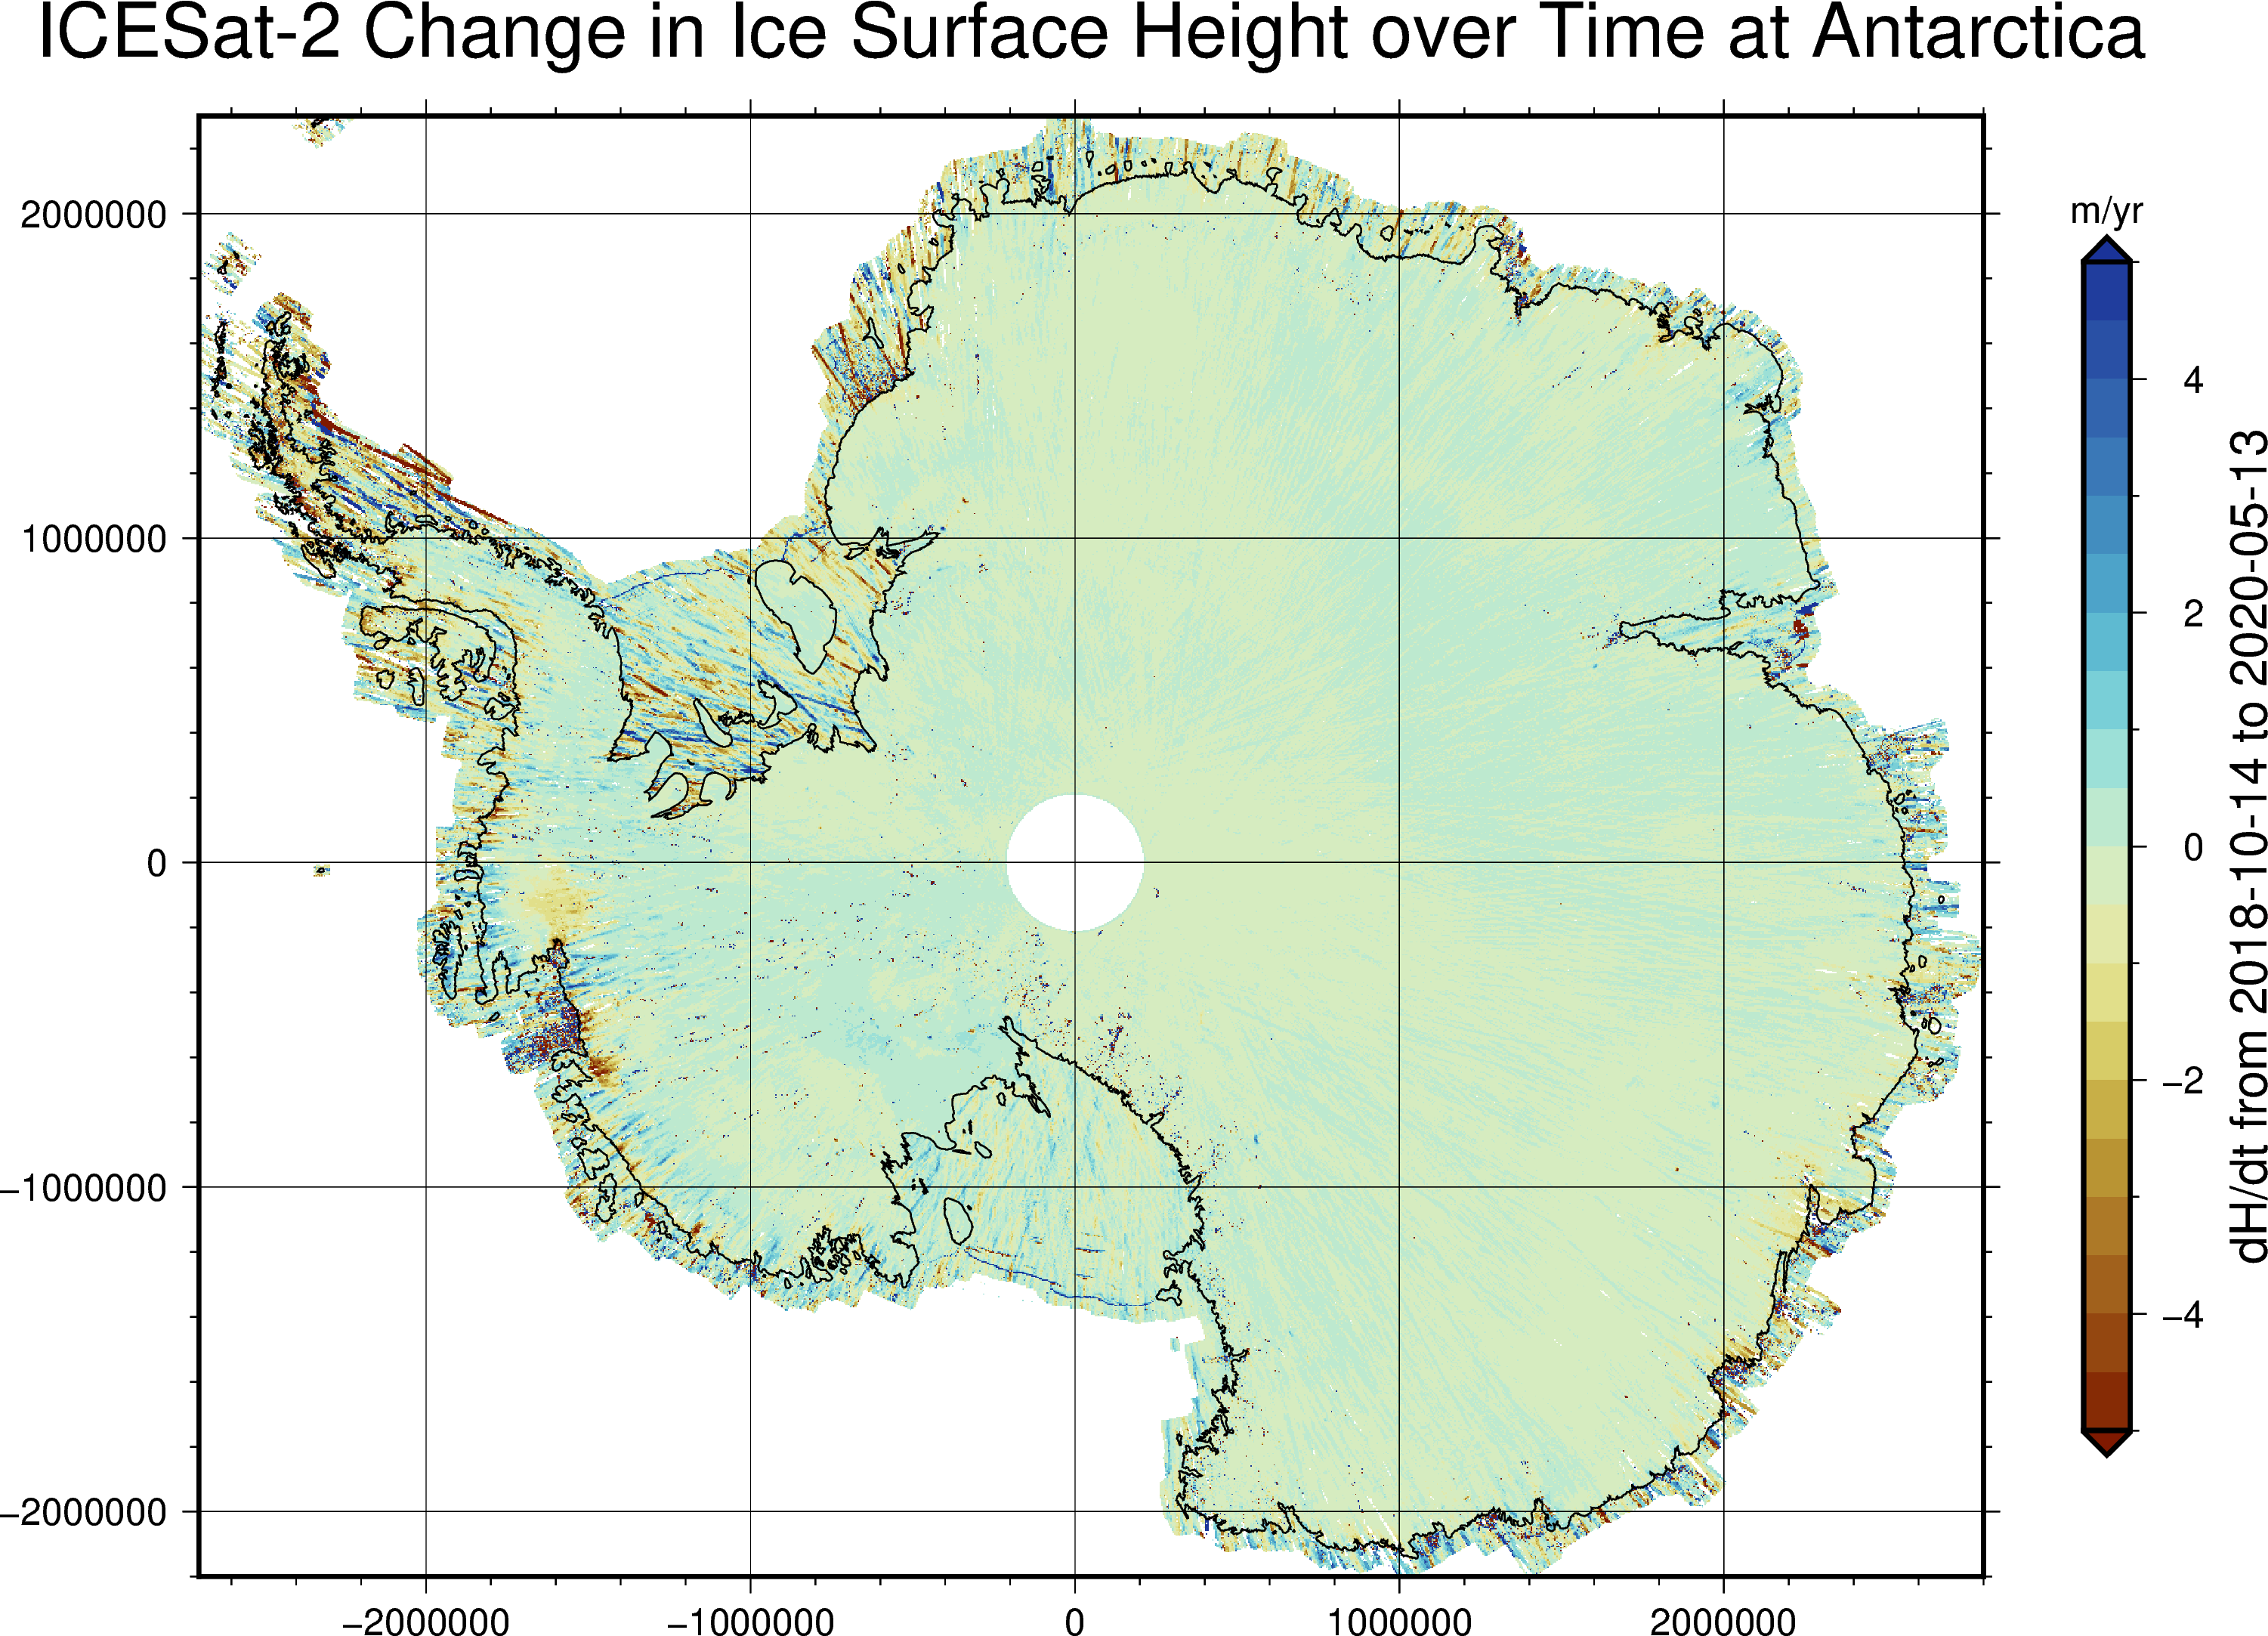

In [30]:
# Plot our map!
scale: int = region.scale
fig = pygmt.Figure()
pygmt.makecpt(cmap="roma", series=[-5, 5, 0.5])
fig.grdimage(
    grid=agg_grid,
    region=region.bounds(),
    projection=f"x1:{scale}",
    frame=[
        "afg",
        f'WSne+t"ICESat-2 Change in Ice Surface Height over Time at {region.name}"',
    ],
    Q=True,
)
fig.colorbar(
    position="JCR+e",
    frame=["af", f'x+l"dH/dt from {min_date} to {max_date}"', "y+lm/yr"],
)
# for subglacial_lake in subglacial_lakes:
#    fig.plot(data=subglacial_lake, L=True, pen="thinnest")
fig.coast(
    region=region.bounds(),
    projection=f"s0/-90/-71/1:{scale}",
    area_thresh="+ag",
    resolution="i",
    shorelines="0.5p",
    V="q",
)
fig.savefig(f"figures/plot_atl11_dhdt_{placename}_{min_date}_{max_date}.png")
fig.show(width=600)

# Along track plots of subglacial lake drainage/filling events

Let's take a closer look at one potential
subglacial lake filling event at Whillans Ice Stream.
We'll plot a cross-section view of
ice surface height changes over time,
along an ICESat-2 reference ground track.

In [32]:
# Subset dataset to geographic region of interest
placename: str = "whillans_downstream"  # "whillans_upstream"
region: deepicedrain.Region = regions[placename]
ds_subset: xr.Dataset = region.subset(ds=ds_dhdt)

In [33]:
# Convert xarray.Dataset to pandas.DataFrame for easier analysis
df_many: pd.DataFrame = ds_subset.to_dataframe().dropna()
# Add a UTC_time column to the dataframe
df_many["utc_time"] = deepicedrain.deltatime_to_utctime(dataarray=df_many.delta_time)

In [34]:
def dhdt_plot(
    cycle: int = 7,
    dhdt_variable: str = "dhdt_slope",
    dhdt_range: tuple = (1, 10),
    rasterize: bool = False,
    datashade: bool = False,
) -> hv.element.chart.Scatter:
    """
    ICESat-2 rate of height change over time (dhdt) interactive scatter plot.
    Uses HvPlot, and intended to be used inside a Panel dashboard.
    """
    df_ = df_many.query(
        expr="cycle_number == @cycle & "
        "abs(dhdt_slope) > @dhdt_range[0] & abs(dhdt_slope) < @dhdt_range[1]"
    )
    return df_.hvplot.scatter(
        title=f"ICESat-2 Cycle {cycle} {dhdt_variable}",
        x="x",
        y="y",
        c=dhdt_variable,
        cmap="gist_earth" if dhdt_variable == "h_corr" else "BrBG",
        clim=None,
        # by="cycle_number",
        rasterize=rasterize,
        datashade=datashade,
        dynspread=datashade,
        hover=True,
        hover_cols=["referencegroundtrack", "dhdt_slope", "h_corr"],
        colorbar=True,
        grid=True,
        frame_width=1000,
        frame_height=600,
        data_aspect=1,
    )

In [ ]:
# Interactive holoviews scatter plot to find referencegroundtrack needed
# Tip: Hover over the points, and find those with high 'dhdt_slope' values
layout: pn.layout.Column = pn.interact(
    dhdt_plot,
    cycle=pn.widgets.IntSlider(name="Cycle Number", start=2, end=7, step=1, value=7),
    dhdt_variable=pn.widgets.RadioButtonGroup(
        name="dhdt_variables",
        value="dhdt_slope",
        options=["referencegroundtrack", "dhdt_slope", "h_corr"],
    ),
    dhdt_range=pn.widgets.RangeSlider(
        name="dhdt range ±", start=0, end=20, value=(1, 10), step=0.25
    ),
    rasterize=pn.widgets.Checkbox(name="Rasterize"),
    datashade=pn.widgets.Checkbox(name="Datashade"),
)
dashboard: pn.layout.Column = pn.Column(
    pn.Row(
        pn.Column(layout[0][1], align="center"),
        pn.Column(layout[0][0], layout[0][2], align="center"),
        pn.Column(layout[0][3], layout[0][4], align="center"),
    ),
    layout[1],
)
# dashboard

In [ ]:
# Show dashboard in another browser tab
dashboard.show()

In [37]:
# Select one Reference Ground track to look at
# rgts: list = [135] # Whillans downstream
rgts: list = [236, 501]  # , 562, 1181]  # Whillans_upstream
for rgt in rgts:
    df_rgt: pd.DataFrame = df_many.query(expr="referencegroundtrack == @rgt")

    # Save track data to CSV for crossover analysis later
    df_rgt[["x", "y", "h_corr", "utc_time"]].to_csv(
        f"X2SYS/track_{rgt}.tsv",
        sep="\t",
        index=False,
        date_format="%Y-%m-%dT%H:%M:%S.%fZ",
    )
print(f"Looking at Reference Ground Tracks: {rgts}")

Looking at Reference Ground Tracks: [236, 501]


In [38]:
# Select one laser pair (out of three) based on y_atc field
# df = df_rgt.query(expr="y_atc < -100")  # left
df = df_rgt.query(expr="abs(y_atc) < 100")  # centre
# df = df_rgt.query(expr="y_atc > 100")  # right

In [ ]:
# Interactive scatter plot of height along one laser pair track, over time
df.hvplot.scatter(
    x="x_atc",
    y="h_corr",
    by="cycle_number",
    hover=True,
    hover_cols=["x", "y", "dhdt_slope"],
)

In [40]:
# Filter points to those with significant dhdt values > +/- 0.2 m/yr
# TODO Use Hausdorff Distance to get location of maximum change!!!
df = df.query(expr="abs(dhdt_slope) > 0.2 & h_corr < 250")

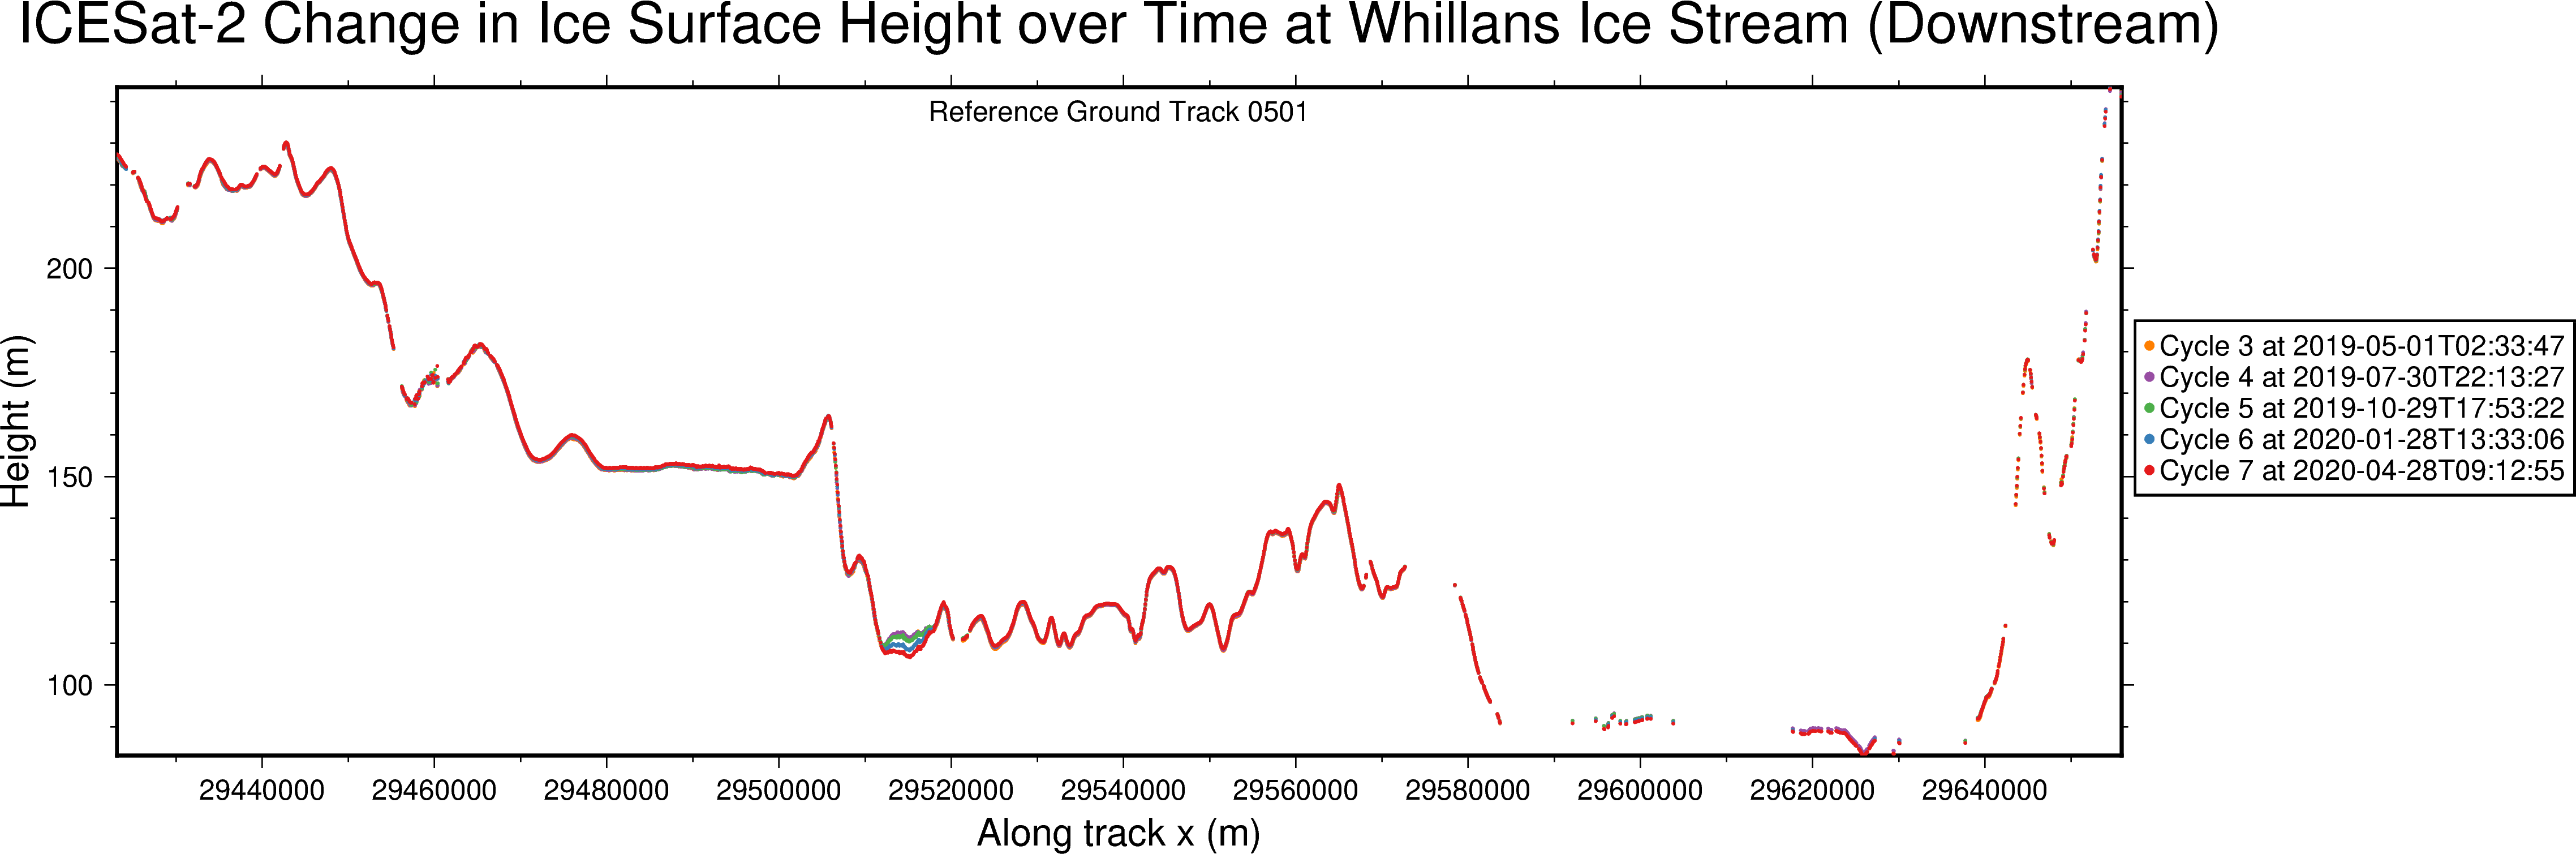

In [41]:
# Plot 2D along track view of
# Ice Surface Height Changes over Time
fig = pygmt.Figure()
# Setup map frame, title, axis annotations, etc
fig.basemap(
    projection="X30c/10c",
    region=[df.x_atc.min(), df.x_atc.max(), df.h_corr.min(), df.h_corr.max()],
    frame=[
        rf'WSne+t"ICESat-2 Change in Ice Surface Height over Time at {region.name}"',
        'xaf+l"Along track x (m)"',
        'yaf+l"Height (m)"',
    ],
)
fig.text(
    text=f"Reference Ground Track {rgt:04d}", position="TC", offset="jTC0c/0.2c", V="q"
)
# Colors from https://colorbrewer2.org/#type=qualitative&scheme=Set1&n=7
cycle_colors = {3: "#ff7f00", 4: "#984ea3", 5: "#4daf4a", 6: "#377eb8", 7: "#e41a1c"}
for cycle, color in cycle_colors.items():
    df_ = df.query(expr="cycle_number == @cycle").copy()
    if len(df_) > 0:
        # Get x, y, time
        data = np.column_stack(tup=(df_.x_atc, df_.h_corr))
        time_nsec = deepicedrain.deltatime_to_utctime(dataarray=df_.delta_time.mean())
        time_sec = np.datetime_as_string(arr=time_nsec.to_datetime64(), unit="s")
        label = f'"Cycle {cycle} at {time_sec}"'

        # Plot data points
        fig.plot(data=data, style="c0.05c", color=color, label=label)
        # Plot line connecting points
        # fig.plot(data=data, pen=f"faint,{color},-", label=f'"+g-1l+s0.15c"')

fig.legend(S=3, position="JMR+JMR+o0.2c", box="+gwhite+p1p")
fig.savefig(f"figures/alongtrack_atl11_dh_{placename}_{rgt}.png")
fig.show()

# Crossover Track Analysis

To increase the temporal resolution of
our ice elevation change analysis
(i.e. at time periods less than
the 91 day repeat cycle of ICESat-2),
we can look at the locations where the
ICESat-2 tracks intersect and get the
height values there!
Uses [x2sys_cross](https://docs.generic-mapping-tools.org/6.1/supplements/x2sys/x2sys_cross).

References:
- Wessel, P. (2010). Tools for analyzing intersecting tracks: The x2sys package.
Computers & Geosciences, 36(3), 348–354. https://doi.org/10.1016/j.cageo.2009.05.009

In [43]:
# Initialize X2SYS database in the X2SYS/ICESAT2 folder
tag = "X2SYS"
os.environ["X2SYS_HOME"] = os.path.abspath(tag)
os.getcwd()
pygmt.x2sys_init(
    tag="ICESAT2",
    fmtfile=f"{tag}/ICESAT2/xyht",
    suffix="tsv",
    units=["de", "se"],  # distance in metres, speed in metres per second
    gap="d250e",  # distance gap up to 250 metres allowed
    force=True,
    verbose="q",
)

In [44]:
# Run crossover analysis on all tracks
rgts: list = [236, 501, 562, 1181]
tracks = [f"{tag}/track_{i}.tsv" for i in rgts]
assert all(os.path.exists(k) for k in tracks)

df_cross: pd.DataFrame = pygmt.x2sys_cross(
    tracks=tracks,
    tag="ICESAT2",
    region=[-400000, -200000, -550000, -500000],
    interpolation="l",  # linear interpolation
    coe="e",  # external crossovers
    trackvalues=True,  # Get track 1 height (h_1) and track 2 height (h_2)
    # trackvalues=False,  # Get crossover error (h_X) and mean height value (h_M)
    # outfile="xover_236_562.tsv"
)
df: pd.DataFrame = df_cross.dropna().reset_index(drop=True)  # drop rows with NaN values
# Report on how many unique crossover intersections there were
# df.plot.scatter(x="x", y="y")  # quick plot of our crossover points
print(
    f"{len(df.groupby(by=['x', 'y']))} crossover intersection point locations found "
    f"with {len(df)} crossover height-time pairs "
    f"over {len(tracks)} tracks"
)

30 crossover intersection point locations found with 460 crossover height-time pairs over 4 tracks


In [45]:
# Calculate crossover error
df["h_X"]: pd.Series = df.h_2 - df.h_1  # crossover error (i.e. height difference)
df["t_D"]: pd.Series = df.t_2 - df.t_1  # elapsed time in ns (i.e. time difference)
ns_in_yr: int = (365.25 * 24 * 60 * 60 * 1_000_000_000)  # nanoseconds in a year
df["dhdt"]: pd.Series = df.h_X / (df.t_D.astype(np.int64) / ns_in_yr)

In [46]:
# Get some summary statistics of our crossover errors
sumstats: pd.DataFrame = df[["h_X", "t_D", "dhdt"]].describe()
# Find location with highest absolute crossover error, and most sudden height change
max_h_X: pd.Series = df.iloc[np.nanargmax(df.h_X.abs())]  # highest crossover error
max_dhdt: pd.Series = df.iloc[df.dhdt.argmax()]  # most sudden change in height

### 2D Map view of crossover points

Bird's eye view of the crossover points
overlaid on top of the ICESat-2 tracks.

In [ ]:
# 2D plot of crossover locations
var: str = "h_X"
fig = pygmt.Figure()
# Setup basemap
region = np.array([df.x.min(), df.x.max(), df.y.min(), df.y.max()])
buffer = np.array([-2000, +2000, -2000, +2000])
fig.basemap(frame=["WSne", "af"], region=region + buffer, projection="X5c")
pygmt.makecpt(cmap="batlow", series=[sumstats[var]["25%"], sumstats[var]["75%"]])
# Plot actual track points
[fig.plot(data=track, color="green", style="c0.01c") for track in tracks]
# Plot crossover point locations
fig.plot(x=df.x, y=df.y, color=df.h_X, cmap=True, style="c0.1c", pen="thinnest")
fig.colorbar(position="JMR", frame=['x+l"Crossover Error"', "y+lm"])
fig.savefig("figures/crossover_area.png")
fig.show()

### 1D plots of height changing over time

Plot height change over time at:

1. One single crossover point location
2. Many crossover locations over an area

In [48]:
# Tidy up dataframe first using pd.wide_to_long
# I.e. convert 't_1', 't_2', 'h_1', 'h_2' columns into just 't' and 'h'.
df["id"] = df.index
df_th: pd.DataFrame = pd.wide_to_long(
    df=df[["id", "x", "y", "t_1", "t_2", "h_1", "h_2"]],
    stubnames=["t", "h"],
    i="id",
    j="track",
    sep="_",
)
df_th = df_th.reset_index(level="track").drop_duplicates(ignore_index=True)

4.23 metres height change at -320982.049267, -518046.31110299996


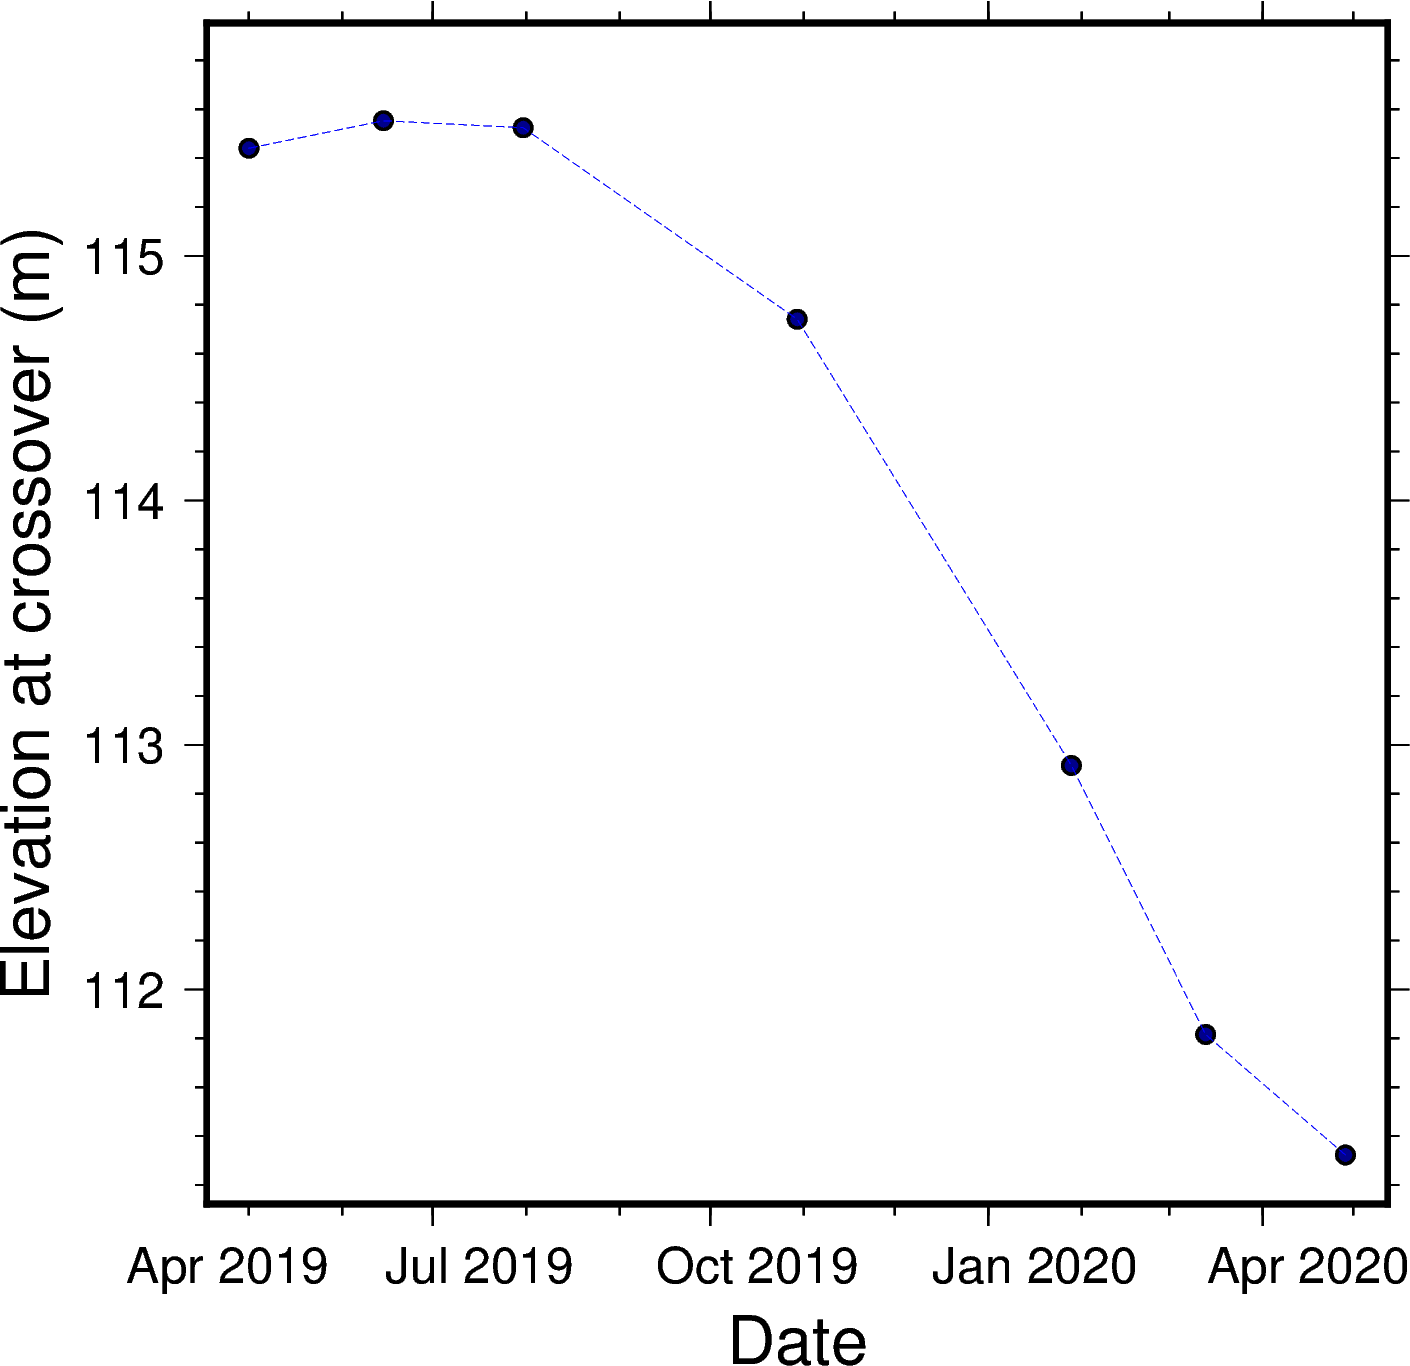

In [49]:
# 1D Plot at location with **maximum** absolute crossover height error (max_h_X)
df_max = df_th.query(expr="x == @max_h_X.x & y == @max_h_X.y").sort_values(by="t")
print(f"{round(max_h_X.h_X, 2)} metres height change at {max_h_X.x}, {max_h_X.y}")
t_min = (df_max.t.min() - pd.Timedelta(2, unit="W")).isoformat()
t_max = (df_max.t.max() + pd.Timedelta(2, unit="W")).isoformat()
h_min = df_max.h.min() - 0.2
h_max = df_max.h.max() + 0.4

fig = pygmt.Figure()
fig.basemap(
    projection="X10c/10c",
    region=[t_min, t_max, h_min, h_max],
    frame=[f"WSne", "xaf+lDate", 'yaf+l"Elevation at crossover (m)"'],
)
# Plot data points
fig.plot(x=df_max.t, y=df_max.h, style="c0.15c", color="darkblue", pen="thin")
# Plot dashed line connecting points
fig.plot(x=df_max.t, y=df_max.h, pen=f"faint,blue,-", label=f'"+g-1l+s0.15c"')
fig.savefig("figures/crossover_one.png")
fig.show()

In [ ]:
# 1D plots of a crossover area, all the height points over time
t_min = (df_th.t.min() - pd.Timedelta(2, unit="W")).isoformat()
t_max = (df_th.t.max() + pd.Timedelta(2, unit="W")).isoformat()
h_min = df_th.h.min() - 0.2
h_max = df_th.h.max() + 0.2
region = [t_min, t_max, h_min, h_max]

fig = pygmt.Figure()
fig.basemap(
    projection="X10c/10c",
    region=region,
    frame=["WSne", "xaf+lDate", "yaf+lElevation(m)"],
)
crossovers = df_th.groupby(by=["x", "y"])
pygmt.makecpt(cmap="hawaii", series=[1, len(crossovers) + 1, 1])
for i, ((x_coord, y_coord), indexes) in enumerate(crossovers.indices.items()):
    df_ = df_th.loc[indexes].sort_values(by="t")
    fig.plot(
        x=df_.t,
        y=df_.h,
        Z=i,
        style="c0.15c",
        # color=df_.index.get_level_values("track"),
        cmap=True,
        pen="thin+z",
    )
    # Plot line connecting points
    fig.plot(
        x=df_.t, y=df_.h, Z=i, pen=f"faint,+z,-", cmap=True
    )  # , label=f'"+g-1l+s0.15c"')
fig.colorbar()
# fig.savefig("figures/crossover_many.png")
fig.show()